In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [3]:
with open('data/item_codes.yaml') as fin:
    ITEM_CODES = yaml.safe_load(fin)

In [4]:
cohorts = pd.read_parquet('data/hh-cohorts.parquet')

In [21]:
def food_basket(df):
    freq_mul, item_codes = np.array(ITEM_CODES['FOOD']).T
    cons_values = df[item_codes] * freq_mul.reshape(1, -1)
    return (cons_values.sum(axis=1) / 12 * df['multiplier']).sum() / df['multiplier'].sum()


def _default_basket(df, codes, norm=12):
    return (df[codes].sum(axis=1) / norm * df['multiplier']).sum() / df['multiplier'].sum()

def edu_basket(df):
    item_codes = ITEM_CODES['EDUCATION']
    return _default_basket(df, item_codes)

def health_basket(df):
    item_codes = ITEM_CODES['HEALTH']
    return _default_basket(df, item_codes)

def utilities_basket(df):
    item_codes = ITEM_CODES['UTILITIES']
    return _default_basket(df, item_codes, norm=1)

def assets_basket(df):
    item_codes = ITEM_CODES['ASSETS']
    return _default_basket(df, item_codes)

In [6]:
health = pd.read_parquet('data/health-indicators.parquet')
cons = pd.read_parquet('data/baskets-consumption-value.parquet')
mult = pd.read_parquet('data/hh_details.parquet')['multiplier']

In [55]:
df = pd.concat([health, cons, mult], axis=1, verify_integrity=True).loc[cohorts.index]
df['cohort_id'] = cohorts['cohort_id']

# Drop the cohorts that have only one value of 'is_hhmem_pmjay'
chs = df.groupby('cohort_id')['is_hhmem_pmjay'].nunique()
to_drop = chs[chs < 2].index
df.drop(df[df['cohort_id'].isin(to_drop)].index, axis=0, inplace=True)

In [14]:
# Treatment - is hhmem pmjay

In [57]:
def get_baskets(df):
    return pd.Series({
        'food': food_basket(df),
        'health': health_basket(df),
        'education': edu_basket(df),
        'utilities': utilities_basket(df),
        'assets': assets_basket(df)
    })

baskets = df.groupby(['cohort_id', 'is_hhmem_pmjay']).apply(get_baskets)

In [59]:
def l1(df):
    x, y = df.values
    return np.abs(x - y).sum()

bdiff = baskets.groupby(baskets.index.get_level_values(0)).apply(l1)

<Axes: >

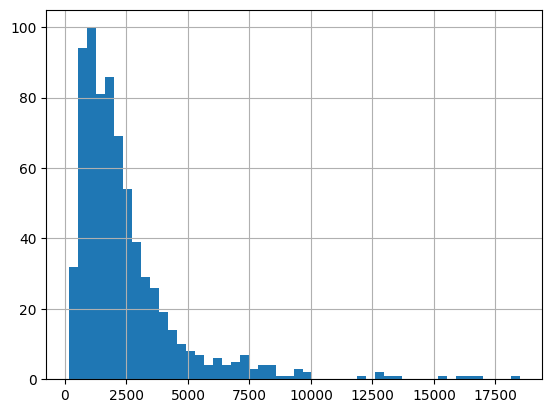

In [62]:
bdiff.hist(bins=50)

In [63]:
q95 = bdiff.quantile(0.95)
q05 = bdiff.quantile(0.05)

In [72]:
higher = bdiff[bdiff >= q95]
lower = bdiff[bdiff >= q05]

In [81]:
baskets.loc[higher.sort_values(ascending=False).index].head(20)

food       health    education    utilities  \
cohort_id is_hhmem_pmjay                                                        
5099      1               10256.666667  1095.833333  2041.666667  1546.000000   
          2               17246.223885   493.894018  1201.412605  2783.097661   
3608      1               19249.261060   461.562740  1571.775156  1735.459171   
          2                7559.979129   141.512331   369.428583  1128.242955   
998       1               24580.000000  1095.000000     0.000000  1679.000000   
          2               10700.105248   146.944794   211.979026  1667.422158   
5120      1                7277.727526    78.059100     0.000000  1282.613554   
          2                9732.330724   350.281524   262.946333  1989.333156   
3308      1               12947.333333    83.333333  1375.000000  5909.000000   
          2               20620.111422   380.420567  1248.425582  2321.533508   
4187      1               22608.000000  2585.833333   566.666667  1208.000000   
          2               12215.208077   269.355161   569.648906  1741.572762   
81        1               11935.386193   378.151521   840.937430  1964.639738   
          2               24456.752161   260.252104   942.344839  2068.007740   
5580      1               19218.938129   381.462186   982.278047  1225.770993   
          2                8724.377282   183.840708   314.592625   991.745976   
79        1                8899.352509   323.306716   816.630341  1703.182972   
          2               20311.941693   210.646142   955.049603  1833.376338   
3287      1               21303.000000   340.666667     0.000000   979.000000   
          2               12101.787574   134.439793   496.477963  1583.051041   

                                assets  
cohort_id is_hhmem_pmjay                
5099      1                 858.333333  
          2                9668.406924  
3608      1                4347.952782  
          2                1277.905220  
998       1                2866.666667  
          2                1475.839710  
5120      1               13471.567707  
          2                 941.642086  
3308      1                 708.333333  
          2                4553.425098  
4187      1                1312.500000  
          2                1159.905150  
81        1                1159.409861  
          2                1450.110328  
5580      1                3037.892386  
          2                1695.320846  
79        1                 626.605290  
          2                1570.406691  
3287      1                1140.833333  
          2                2747.719264

In [86]:
baskets.loc[lower.sort_values().index].head(20)

food      health   education    utilities  \
cohort_id is_hhmem_pmjay                                                      
664       1                6166.561448   78.871690  418.436259   874.649592   
          2                6496.244042  202.441209  353.478809   895.430428   
683       1                6579.325967  181.697679  632.196897   957.416660   
          2                6742.708493  396.991332  469.427049   963.270314   
1607      1                5983.335167  105.942656  269.967878   918.837618   
          2                5736.162529   71.623310  306.799101  1078.977073   
2238      1                5825.690682  174.613289  370.243837  1359.276343   
          2                6058.072339  198.118119  282.464424  1282.558829   
4602      1                7264.641673  112.246548  175.771041  1147.433222   
          2                7232.952096  169.153704  146.798669  1103.905309   
1539      1                4881.000707  256.575057  208.696610  1024.967258   
          2                5134.953432   82.235607  184.487401   973.470227   
1699      1                6085.617612  208.202887  289.024907   667.854569   
          2                6386.944643   60.188031  239.837535   627.402277   
838       1               15490.594767  275.887762  403.412229  1348.627616   
          2               15469.908083  176.481620  772.731035  1276.252581   
3957      1                9548.913833  368.299316  758.392156  1256.054163   
          2                9308.433911  121.492154  700.450481  1234.481204   
4334      1                7159.820571  119.774484  323.940219  1125.129582   
          2                7371.371134  276.488299  401.894100  1165.797616   

                               assets  
cohort_id is_hhmem_pmjay               
664       1                674.466878  
          2                694.396115  
683       1                842.660419  
          2                831.027883  
1607      1                606.783450  
          2                698.571388  
2238      1               1122.869754  
          2                972.138744  
4602      1               1256.663043  
          2                843.930770  
1539      1                521.035151  
          2                450.742560  
1699      1                927.230034  
          2                963.153503  
838       1               2157.967952  
          2               2181.321577  
3957      1                785.564083  
          2                807.728373  
4334      1                893.928930  
          2                996.579243

In [88]:
cohorts[cohorts['cohort_id'] == 683]

,sector,nss_region,max_income_from,hoh_religion,family_size,has_child_elderly,cohort_id
hhid,,,,,,,
47346101,rural,95,self-employment,Hinduism,nuclear,False,683
47346308,rural,95,self-employment,Hinduism,nuclear,False,683
47346313,rural,95,self-employment,Hinduism,nuclear,False,683
47347201,rural,95,self-employment,Hinduism,nuclear,False,683
47347306,rural,95,self-employment,Hinduism,nuclear,False,683
...,...,...,...,...,...,...,...
43767303,rural,95,self-employment,Hinduism,nuclear,False,683
47565301,rural,95,self-employment,Hinduism,nuclear,False,683
47565305,rural,95,self-employment,Hinduism,nuclear,False,683
